## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import csv
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load and explore the data set

In [2]:
#  read the CSV file
d1 = pd.read_csv('sample_data/brighton_clean_data.csv')
d1.head()

,datetime,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,Year,Month,Day,hour
0,2010-01-01 00:00:00,1.9,-0.5,84.25,0.417,100.0,"rain,snow",0.0,0.0,19.4,11.0,999.9,62.2,0.0,0.0,0.0,2010,1,1,0
1,2010-01-01 01:00:00,1.9,-0.5,83.90,0.000,0.0,"rain,snow",0.0,0.0,21.8,19.0,999.8,22.4,0.0,0.0,0.0,2010,1,1,1
2,2010-01-01 02:00:00,1.4,-0.7,85.76,0.000,0.0,"rain,snow",0.0,0.0,17.7,10.0,1000.0,38.0,0.0,0.0,0.0,2010,1,1,2
3,2010-01-01 03:00:00,1.4,-0.7,85.69,0.000,0.0,"rain,snow",0.0,0.0,18.0,11.0,1000.2,66.7,0.0,0.0,0.0,2010,1,1,3
4,2010-01-01 04:00:00,1.3,-0.8,85.72,0.000,0.0,"rain,snow",0.0,0.0,17.4,10.0,1000.5,62.8,0.0,0.0,0.0,2010,1,1,4


## Extract Feature columns

In [3]:
d1_order = d1[['datetime','temp', 'dew','humidity', 'winddir','sealevelpressure', 'cloudcover', 'solarradiation', 'uvindex','solarenergy', 'windspeed']]

# set datetime as a index column
d1_order.set_index('datetime', inplace=True)
d1_order.values.shape, d1_order.shape


((122844, 10), (122844, 10))

## Data splitting

In [4]:
n_tr, n_val = int(0.5*len(d1_order)), int(0.3*len(d1_order))
n_te = len(d1_order) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 61422; validation: 36853; test: 24569


### Data Normalization

In [5]:
# Get the data from the dataframe
data = d1_order.values
data_base = d1_order.values
data_base = data[:n_tr, :]

print(data.shape)
assert data.shape[0] == len(d1_order)
assert data.shape[1] == len(d1_order.columns)

# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY.
# We'll use it on the validation and test sets.
scaler = StandardScaler()
# find parameters using training set only
scaler.fit(data[:n_tr, :])
# transform the whole data set
data = scaler.transform(data)

# 'solarenergy' and 'windspeed' not transformed; still in the original scale
y = d1_order[['solarenergy', 'windspeed']].values

# index of the column that contains the avg_temp in the original array
y_idx = list(d1_order.columns).index('solarenergy')

(122844, 10)


In [6]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 24  # use data from last 2 weeks (14 days) to predict tomorrow's temperature
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 24  # for training

## Create train, validation and testing datasets

In [7]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data=data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  # first 50% for training
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  # 50%-80% for validation
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  # last 20% for test
    )

for X, target in test_dataset:
    print("X shape:", X.shape)  # (batch_size, sequence_length, n_features)
    print("target shape:", target.shape)
    break  # so we only print once

print(len(train_dataset),len(val_dataset),len(test_dataset))

X shape: (24, 24, 10)
target shape: (24, 2)
2559 1535 1022


In [8]:
# Create a function to Ploting training and validation MAE
def plot_hist_regression(hist):
  n_ = len(hist.history['mae'])
  plt.plot(range(1, n_+1), np.asarray(hist.history['mae']), 'bo', label='MAE on training set')
  plt.plot(range(1, n_+1), np.asarray(hist.history['val_mae']), 'b', label='MAE on validation set')
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("MAE (degrees)")
  plt.ylim([0, None])
  # plt.axhline(y=y)
  plt.show()

In [ ]:
# test=data_base[:-delay]
# t0 = [test[:,-1],test[:,-2]]
# t0 = np.array(t0).T
# values = pd.DataFrame(t0)

# dataframe = pd.concat([values.shift(24), values], axis=1)
# dataframe.columns = ['target_0','target_1', 'ori_0','ori_1']

# dataframe=dataframe.fillna(0)

# print(dataframe[:2].shape)

# test_score_1 = mean_squared_error(dataframe[['ori_0','ori_1']], dataframe[['target_0','target_1']])
# # # test_score = test_score/40
# # print('Test MSE: %.3f' % test_score_0)
# print('Test MSE: %.3f' % test_score_1)

In [ ]:
# def naive_method(dataset, scaler):
#     error = 0
#     samples = 0
#     count = 0
#     for X, target in dataset:
#       pred = scaler.inverse_transform(X[0])  # predict last available temperature for each sequence in the batch and un-standardise
#       pred_ = [pred[:,-1],pred[:,-2]]
#       pred_ = np.array(pred_).reshape(24,2)
#       target = target.numpy()

#       try:
#         error += np.sum(np.abs(pred_ - target))
#         samples += X.shape[0]
#       except:
#         print('pass--')
#         pass
#       # samples += X.shape[0]  # batch_size
#       count += 1
#     return error / samples /batch_size # average


# print('MAE on train set = %.2f (degrees Celsius)' % naive_method(train_dataset, scaler))
# print('MAE on validation set = %.2f (degrees Celsius)' % naive_method(val_dataset, scaler))
# # Save MAE on validation for later
# baseline = naive_method(val_dataset, scaler)

## Create a Model

In [ ]:
model_lstm3 = models.Sequential()
model_lstm3.add(layers.LSTM(100, input_shape=(sequence_length, len(d1_order.columns)), recurrent_dropout=0.25, return_sequences=True))  # NEW!
model_lstm3.add(layers.Bidirectional(layers.LSTM(100, input_shape=(sequence_length, len(d1_order.columns)))))  # NEW!!
model_lstm3.add(layers.Dropout(0.3))
model_lstm3.add(layers.Dense(128))
model_lstm3.add(layers.Dropout(0.3))
model_lstm3.add(layers.Dense(64))
model_lstm3.add(layers.Dense(32))
model_lstm3.add(layers.Dense(2))

# Model summary
model_lstm3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 100)           44400     
                                                                 
 bidirectional (Bidirection  (None, 200)               160800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

## Model Fit and Training

In [ ]:
# model_lstm3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# model_lstm3.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.8), loss='mse', metrics=['mae'])

# using Adam optimizer with 0.0001 lerning rate and Mean squared Error as a loss function
model_lstm3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

history_lstm3 = model_lstm3.fit(train_dataset, epochs=20,  # 20 number of epochs
                            validation_data=val_dataset )


# save trained model in to g-drive
model_lstm3.save('sample_data_trained_b24_4.h5')


Epoch 1/20
2559/2559 [==============================] - 216s 81ms/step - loss: 24.1698 - mae: 2.9281 - val_loss: 9.5510 - val_mae: 1.8439
Epoch 2/20
2559/2559 [==============================] - 203s 79ms/step - loss: 8.9636 - mae: 1.8284 - val_loss: 6.4174 - val_mae: 1.4841
Epoch 3/20
2559/2559 [==============================] - 202s 79ms/step - loss: 7.4953 - mae: 1.6493 - val_loss: 6.8003 - val_mae: 1.5255
Epoch 4/20
2559/2559 [==============================] - 205s 80ms/step - loss: 7.2032 - mae: 1.5954 - val_loss: 6.1733 - val_mae: 1.4406
Epoch 5/20
2559/2559 [==============================] - 202s 79ms/step - loss: 6.9322 - mae: 1.5557 - val_loss: 6.3678 - val_mae: 1.4615
Epoch 6/20
2559/2559 [==============================] - 205s 80ms/step - loss: 6.8588 - mae: 1.5414 - val_loss: 5.8565 - val_mae: 1.3942
Epoch 7/20
2559/2559 [==============================] - 202s 79ms/step - loss: 6.7829 - mae: 1.5324 - val_loss: 5.9340 - val_mae: 1.4034
Epoch 8/20
2559/2559 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plot training and Validation MAE

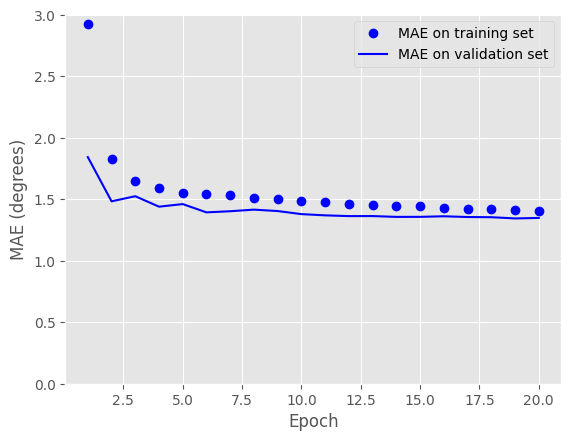

In [ ]:
plot_hist_regression(history_lstm3)

In [9]:
# Load Model and check the model its saved correctly
model_lstm3 = keras.models.load_model('sample_data_trained_b24_4.h5')
model_lstm3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 100)           44400     
                                                                 
 bidirectional (Bidirection  (None, 200)               160800    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

## Model Prediction

The following graphs display the predicted values of solar energy and wind speed by our trained model for the upcoming 24 hours. Our model's predictions closely align with the actual values, demonstrating its accuracy and reliability in forecasting renewable energy variables.

In [10]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]

    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    # print('PLOT DATA',plot_data,'time_steps',time_steps,'----',plot_data[0].shape[0])

    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)

    if title.split(' ')[0] == 'solarenergy':
      plot_fig = 0
    else:
      plot_fig = 1


    print('True Value',plot_data[1][plot_fig], 'Prediction',plot_data[2][plot_fig])

    for i, val in enumerate(plot_data):

      if i:
        # print('-if -i------',i)
        plt.plot(future, plot_data[i][plot_fig], marker[i], markersize=10, label=labels[i])
      else:
        # print('-esle -i------',i)
        plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])


    plt.legend()
    # plt.set_ylabel([time_steps[0], (future + 5)])
    plt.xlim([time_steps[0], (future + 5)* 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

1/1 [==============================] - 1s 1s/step
True Value 0.0 Prediction 0.010482304


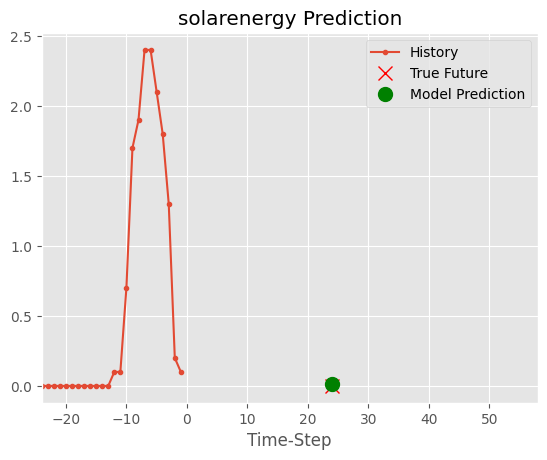

1/1 [==============================] - 0s 34ms/step
True Value 12.1 Prediction 11.898648


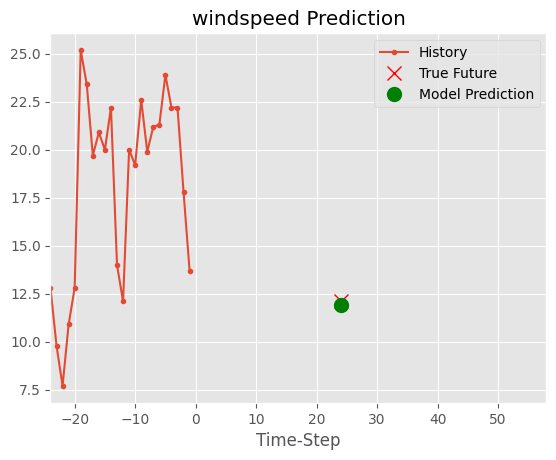

In [11]:
for x, y in test_dataset.take(1):
    unnorm = scaler.inverse_transform(x[0].numpy())

    unnorm_solar = unnorm[:, 8]
    show_plot([unnorm_solar, y[0].numpy(), model_lstm3.predict(x)[0]], 24, "solarenergy Prediction",)

    # show_plot([x[0][:, 9].numpy(), y[0].numpy(), model_lstm3.predict(x)[0]], 24, "Single Step Prediction",

    unnorm_wind = unnorm[:, 9]
    show_plot([unnorm_wind, y[0].numpy(), model_lstm3.predict(x)[0]], 24, "windspeed Prediction",)


    # break


##Assumptions

1.   **Wind Energy Calculations**

     Power (W) = 1/2 x ρ x A x v3
     Power = Watts
      
*   ρ (rho, a Greek letter) = density of the air in kg/m3  -The standard(link is external) density of air is 1.225 kg/m3
*   A = cross-sectional area of the wind in m2 - The turbine has a 24 m diameter, which means the radius is 12 m. Thus, the swept area of the turbine is: (pi)r2 = 3.14159(122) = 452.4 m2
*   v = velocity of the wind in m/s


2.   **Solar Energy Calculation**

3.   **Number of houses in brighton-b5 area.**
houses - 3,067
4.   **average electricity usage per month in UK households is about 350kWh**
5.   **Daily usage 350/31 = 11.29 Kwh**

In [12]:

# convert windspeed  kilometers per hour to miles per hour
def kph_to_ms(kph):
    return (0.277778 * kph)

# Convert solar energy megaW to kilowatt
def mw_to_kw(mw,panels=4):
    return (1000 * mw * panels)

def wind_energy_cal(v3, ρ = 1.225, A=452.4):
    v3 = v3**3
    power_kw = (0.5 * ρ * A * v3)/1000
    return power_kw

Model forecast the next 24 hours of data and subsequently calculate the total energy generated within that period. This involves predicting the energy output for each hour over the next day and then summing up these individual predictions to obtain the total energy generated. By forecasting the energy generation for each hour and aggregating these predictions, we can estimate the overall energy output over the specified timeframe.

1/1 [==============================] - 0s 53ms/step
Solar energy(kWh) prediction for next 24 hour 5900.064016342163
Wind energy(kWh) prediction for next 24 hour 41099.13296127319
Total energy(kWh) prediction for next 24 hour 46999.19697761536


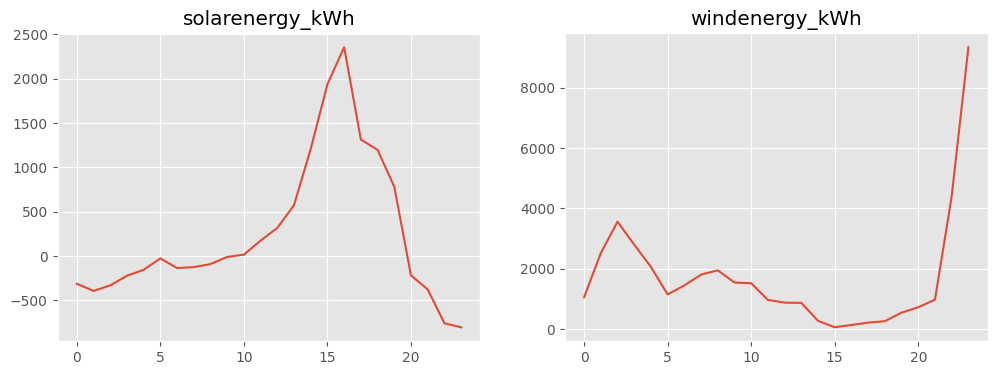

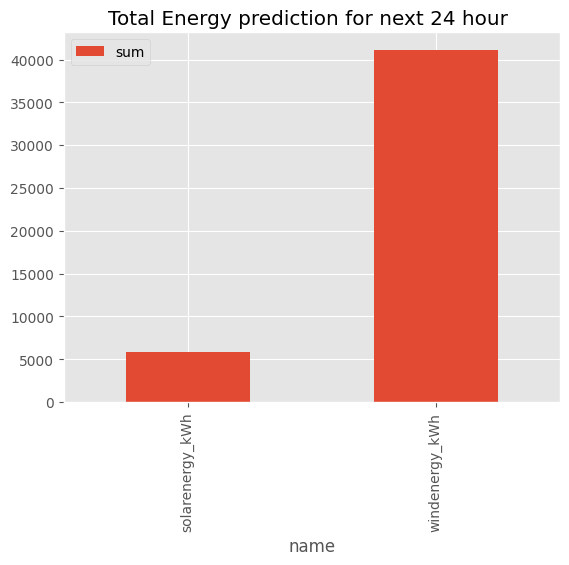

In [15]:
_pred = []
test_size = len(test_dataset)


fig, ax = plt.subplots(1,2,figsize=(12,4))
for i,(x, y) in enumerate(test_dataset):
  # print('---',i)

  if i==test_size-2: # take the last batch
    predict = model_lstm3.predict(x)

df = pd.DataFrame(predict)
# print(df)

# Convert wind speed to wind energy and solar energy
solarenergy_kWh = mw_to_kw(df[0])
windenergy_kWh = wind_energy_cal(df[1])

# Total energy generate next 24 hours
print('Solar energy(kWh) prediction for next 24 hour',sum(solarenergy_kWh))
tot_solarenergy_kWh = sum(solarenergy_kWh)
print('Wind energy(kWh) prediction for next 24 hour',sum(windenergy_kWh))
tot_windenergy_kWh = sum(windenergy_kWh)
print('Total energy(kWh) prediction for next 24 hour',sum(windenergy_kWh)+sum(solarenergy_kWh))
tot_energy = sum(windenergy_kWh)+sum(solarenergy_kWh)

# plot solar and wind energy(KWh) and total of them
df_sum = pd.DataFrame({
    "name" : ["solarenergy_kWh","windenergy_kWh"],
    "sum": [sum(solarenergy_kWh),sum(windenergy_kWh)]
})

ax[0].set_title('solarenergy_kWh')
ax[0].plot(solarenergy_kWh)
ax[1].set_title('windenergy_kWh')
ax[1].plot(windenergy_kWh)
plt.show()

df_sum.plot(x="name", y="sum", kind="bar",title='Total Energy prediction for next 24 hour ')
plt.show()


## Recommandation

calculate and display the surplus energy for both wind and solar sources, along with the surplus of total energy.

In [16]:
# total energy used per day by Brighton -b5 house holders
# number of house holders 1500
tot_consum = 1500 * 11.29
tot_consum

16935.0

providing informative messages regarding the available surplus energy options.

In [29]:
if tot_consum < tot_energy:
  if tot_consum < tot_solarenergy_kWh :
    print(f'Recommended to opt for solar energy, The surplus of solar energy amounts to {round((tot_solarenergy_kWh- tot_consum),3) }(KWh), \nwhile the surplus of total energy stands at {round((tot_energy- tot_consum),3) }(KWh)')

  elif tot_consum < tot_windenergy_kWh:
    print(f'Recommended to opt for wind energy, The surplus of wind energy amounts to { round((tot_windenergy_kWh- tot_consum),3) }(KWh), \nwhile the surplus of total energy stands at {round((tot_energy- tot_consum),3) }(KWh)')
  else:
    print(f'Surplus of total energy is { round((tot_energy-tot_consum),3)}')


Recommended to opt for wind energy, The surplus of wind energy amounts to 24164.133(KWh), 
while the surplus of total energy stands at 30064.197(KWh)
